#  Customer Churn Prediction Using ML Models

## Project Summary: 

- **Goal**: Predict customer churn using machine learning models to identify which customers are likely to leave.
- **Best Model**: GradientBoosting with F1-score = 0.91
- **Business Use**: Helps retain customers by early churn prediction.


#### Importing Libraries and Data Set

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, roc_auc_score) 
from sklearn.metrics import (classification_report, confusion_matrix)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier 
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
df = pd.read_csv(r'C:\Customer_Churn_Data.csv')

#### Understanding the Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       1000 non-null   int64  
 1   Age              1000 non-null   int64  
 2   Gender           1000 non-null   object 
 3   Tenure           1000 non-null   int64  
 4   MonthlyCharges   1000 non-null   float64
 5   ContractType     1000 non-null   object 
 6   InternetService  703 non-null    object 
 7   TotalCharges     1000 non-null   float64
 8   TechSupport      1000 non-null   object 
 9   Churn            1000 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 78.3+ KB


In [4]:
df.head()

,CustomerID,Age,Gender,Tenure,MonthlyCharges,ContractType,InternetService,TotalCharges,TechSupport,Churn
0,1,49,Male,4,88.35,Month-to-Month,Fiber Optic,353.40,Yes,Yes
1,2,43,Male,0,36.67,Month-to-Month,Fiber Optic,0.00,Yes,Yes
2,3,51,Female,2,63.79,Month-to-Month,Fiber Optic,127.58,No,Yes
3,4,60,Female,8,102.34,One-Year,DSL,818.72,Yes,Yes
4,5,42,Male,32,69.01,Month-to-Month,NaN,2208.32,No,Yes


In [5]:
df.tail()

,CustomerID,Age,Gender,Tenure,MonthlyCharges,ContractType,InternetService,TotalCharges,TechSupport,Churn
995,996,42,Male,41,37.14,Month-to-Month,Fiber Optic,1522.74,Yes,Yes
996,997,62,Male,9,80.93,Month-to-Month,NaN,728.37,No,Yes
997,998,51,Female,15,111.72,Month-to-Month,Fiber Optic,1675.80,Yes,Yes
998,999,39,Male,68,65.67,One-Year,NaN,4465.56,No,Yes
999,1000,50,Male,1,56.67,Month-to-Month,NaN,56.67,No,Yes


In [6]:
df.columns

Index(['CustomerID', 'Age', 'Gender', 'Tenure', 'MonthlyCharges',
       'ContractType', 'InternetService', 'TotalCharges', 'TechSupport',
       'Churn'],
      dtype='object')

In [7]:
df.describe()

,CustomerID,Age,Tenure,MonthlyCharges,TotalCharges
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,500.500000,44.674000,18.97300,74.391290,1404.364060
std,288.819436,9.797741,18.89257,25.712083,1571.755048
min,1.000000,12.000000,0.00000,30.000000,0.000000
25%,250.750000,38.000000,5.00000,52.357500,345.217500
50%,500.500000,45.000000,13.00000,74.060000,872.870000
75%,750.250000,51.000000,26.00000,96.102500,1900.175000
max,1000.000000,83.000000,122.00000,119.960000,12416.250000


#### Data Cleaning

In [8]:
# Checking for null values
df.isnull().sum()

CustomerID           0
Age                  0
Gender               0
Tenure               0
MonthlyCharges       0
ContractType         0
InternetService    297
TotalCharges         0
TechSupport          0
Churn                0
dtype: int64

In [9]:
df["InternetService"] = df["InternetService"].fillna("")

In [10]:
df.isnull().sum()

CustomerID         0
Age                0
Gender             0
Tenure             0
MonthlyCharges     0
ContractType       0
InternetService    0
TotalCharges       0
TechSupport        0
Churn              0
dtype: int64

In [11]:
df.duplicated().sum()

0

In [12]:
y = df[["Churn"]]
X = df[["Age","Gender","Tenure","MonthlyCharges"]]

#####  Used  Age, Gender, Tenure, and MonthlyCharges to keep the model simple, fast, and interpretable. These features are always available and provide strong signals for predicting churn without relying on complex service data.

In [13]:
X["Gender"] = X["Gender"].apply(lambda x: 1 if x == "Female" else 0) 
y["Churn"] = y["Churn"].apply(lambda x: 1 if x == "Yes" else 0)

In [14]:
X

,Age,Gender,Tenure,MonthlyCharges
0,49,0,4,88.35
1,43,0,0,36.67
2,51,1,2,63.79
3,60,1,8,102.34
4,42,0,32,69.01
...,...,...,...,...
995,42,0,41,37.14
996,62,0,9,80.93
997,51,1,15,111.72
998,39,0,68,65.67


In [15]:
y

,Churn
0,1
1,1
2,1
3,1
4,1
...,...
995,1
996,1
997,1
998,1


#### Exploratory Data Analysis (EDA)

In [16]:
numeric_columns_data = df.select_dtypes(include = ["number"])

In [17]:
numeric_columns_data.corr()

,CustomerID,Age,Tenure,MonthlyCharges,TotalCharges
CustomerID,1.000000,0.036730,-0.018585,-0.030504,-0.027490
Age,0.036730,1.000000,0.000472,0.006362,-0.001896
Tenure,-0.018585,0.000472,1.000000,-0.014552,0.894868
MonthlyCharges,-0.030504,0.006362,-0.014552,1.000000,0.304893
TotalCharges,-0.027490,-0.001896,0.894868,0.304893,1.000000


#### Observations
* Tenure and TotalCharges are highly correlated (0.89) - total charges are mostly dependent on how long a customer has stayed.
* MonthlyCharges and TotalCharges show a moderate relationship (0.30) - some customers may have high monthly charges but short tenure.
* CustomerID has no correlation - it should be excluded from model training.
* Age shows negligible correlation with billing or tenure.

#### Churn Distribution

In [18]:
df["Churn"].value_counts()

Churn
Yes    883
No     117
Name: count, dtype: int64

(array([0, 1]), [Text(0, 0, 'Yes'), Text(1, 0, 'No')])

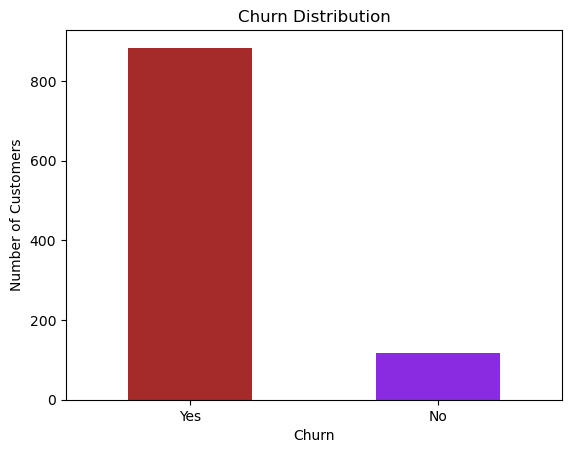

In [19]:
df["Churn"].value_counts().plot(kind="bar",color=['brown', 'blueviolet'])
plt.title("Churn Distribution")
plt.xlabel("Churn")
plt.ylabel("Number of Customers")
plt.xticks(rotation=0)

#### Understanding Churn Count vs Churn Rate

- **Churn Count** shows how many customers left in each group.
- **Churn Rate** shows what *percentage* of customers left in each group.

#### Churn Distribution by Age Group

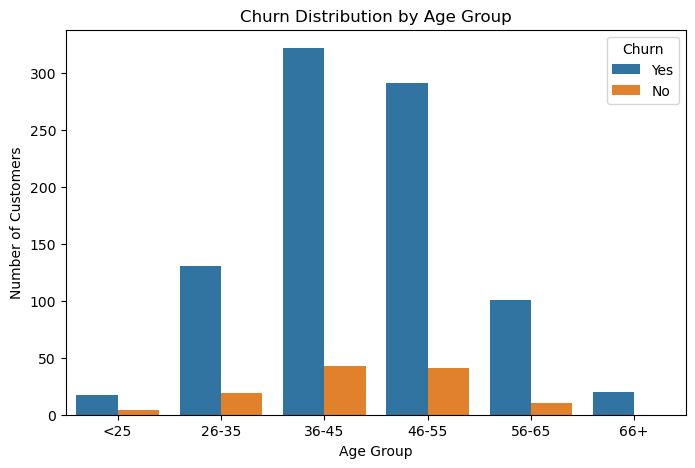

In [20]:
# Define bins and labels inline
age_bins = [12, 25, 35, 45, 55, 65, 85]
age_labels = ['<25', '26-35', '36-45', '46-55', '56-65', '66+']

# Create the plot
plt.figure(figsize=(8, 5))
sns.countplot(
    x=pd.cut(df['Age'], bins=age_bins, labels=age_labels),
    hue=df['Churn']
)

# Customize the chart
plt.title('Churn Distribution by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Customers')
plt.legend(title='Churn')
plt.show()

#### Observations
* Churn is highest among customers aged 36–45 and 46–55, indicating these are the most at-risk segments.
* Customers below 25 show the lowest churn counts.
* 56–65 age group shows moderate churn but very few retained customers.

#### Churn Distribution by Tenure Group

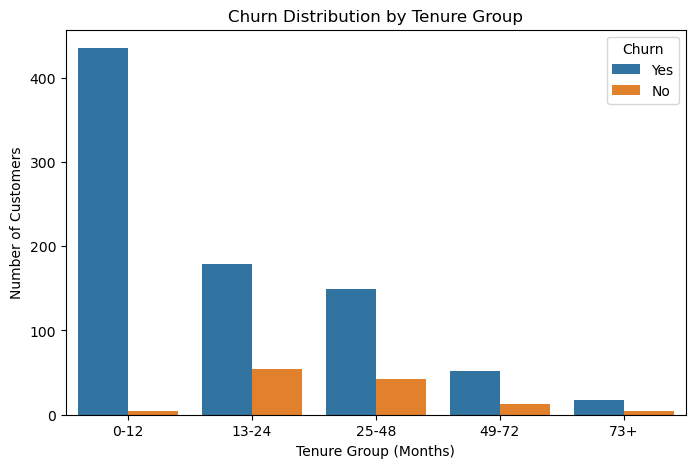

In [21]:
# Define tenure bins and labels
tenure_bins = [0, 12, 24, 48, 72, 130] 
tenure_labels = ['0-12', '13-24', '25-48', '49-72', '73+']

# Create the plot
plt.figure(figsize=(8, 5))
sns.countplot(
    x=pd.cut(df['Tenure'], bins=tenure_bins, labels=tenure_labels),
    hue=df['Churn'],
    palette=['#1f77b4', '#ff7f0e']
)

# Customize the chart
plt.title('Churn Distribution by Tenure Group')
plt.xlabel('Tenure Group (Months)')
plt.ylabel('Number of Customers')
plt.legend(title='Churn')
plt.show()

#### Observations
* Tenure group 0–12 months has the highest churn, indicating that most customers leave within their first year.
* 13–24 and 25–48 month groups show a moderate churn drop, indicating that once customers cross the 1-year mark, their likelihood to churn gradually declines.
*  The 73+ month group has the lowest churn, signaling successful long-term retention, likely due to service familiarity or commitment.

#### Churn Distribution by Monthly Charges

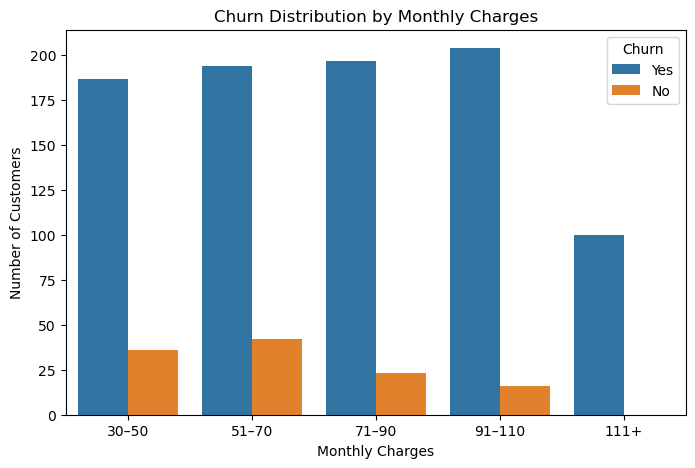

In [22]:
# Define tenure bins and labels
monthly_bins = [30, 50, 70, 90, 110, 130]
monthly_labels = ['30–50', '51–70', '71–90', '91–110', '111+']

# Create the plot
plt.figure(figsize=(8, 5))
sns.countplot(
    x=pd.cut(df['MonthlyCharges'], bins=monthly_bins, labels=monthly_labels),
    hue=df['Churn'],
    palette=['#1f77b4', '#ff7f0e']
)

# Customize the chart
plt.title('Churn Distribution by Monthly Charges')
plt.xlabel('Monthly Charges')
plt.ylabel('Number of Customers')
plt.legend(title='Churn')
plt.show()

#### Observations
* Churn is consistently high across all price ranges, but especially dominant in the 91–110.
* The 111+ monthly charges group shows zero retention, indicating that premium or expensive plans are struggling to retain customers
* Low-charge segments (30–50) still experience notable churn, possibly indicating dissatisfaction even at basic service levels.

#### Churn Distribution by Gender

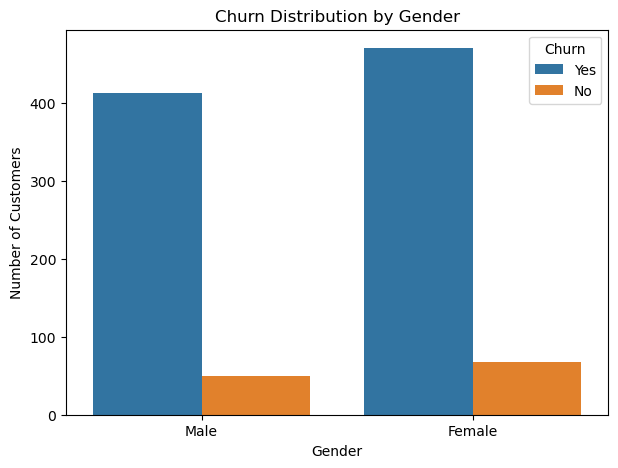

In [23]:
# Create the plot
plt.figure(figsize=(7, 5))
sns.countplot(
    data=df,
    x='Gender',
    hue='Churn',
    palette=['#1f77b4', '#ff7f0e']
)

# Customize the chart
plt.title('Churn Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Customers')
plt.legend(title='Churn')
plt.show()

#### Observations
* Churn is high for both genders, but slightly more females have churned than males.
* Retention (Churn = No) is slightly better among females compared to males, though the difference is not substantial.

#### Churn Rate by Age Group

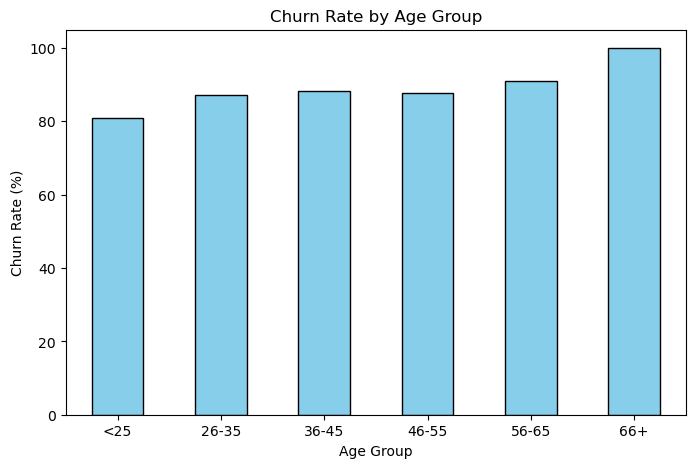

In [24]:
# Compute churn rate per age group
age_churn = df[df['Churn'] == 'Yes'].groupby(pd.cut(df['Age'], bins=age_bins, labels=age_labels)).size()
age_total = df.groupby(pd.cut(df['Age'], bins=age_bins, labels=age_labels)).size()
age_churn_rate = (age_churn / age_total * 100).round(2)

# Plot
plt.figure(figsize=(8, 5))
age_churn_rate.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Churn Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Churn Rate (%)')
plt.xticks(rotation=0)
plt.show()

#### Observations
* Customers aged 66+ have the highest churn rate. 
* The 56–65 age group also shows elevated churn, suggesting older customers are more prone to leaving.
* Younger groups (<25, 26–35) have slightly lower churn rates but still reflect notable risk.

#### Churn Rate by Monthly Charges

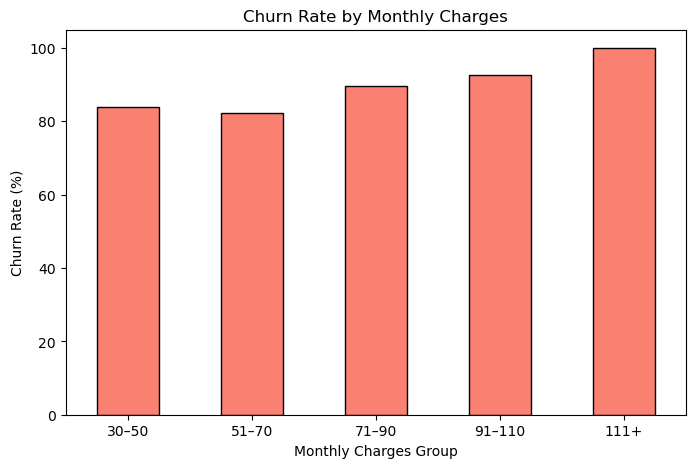

In [25]:
# Compute churn rate per MonthlyCharges
monthly_churn = df[df['Churn'] == 'Yes'].groupby(pd.cut(df['MonthlyCharges'], bins=monthly_bins, labels=monthly_labels)).size()
monthly_total = df.groupby(pd.cut(df['MonthlyCharges'], bins=monthly_bins, labels=monthly_labels)).size()
monthly_churn_rate = (monthly_churn / monthly_total * 100).round(2)

# Plot
plt.figure(figsize=(8, 5))
monthly_churn_rate.plot(kind='bar', color='salmon', edgecolor='black')
plt.title('Churn Rate by Monthly Charges')
plt.xlabel('Monthly Charges Group')
plt.ylabel('Churn Rate (%)')
plt.xticks(rotation=0)
plt.show()

#### Observations
* Customers paying over 111 have a high churn rate, the highest among all groups, indicating serious dissatisfaction or affordability issues in premium tiers.
* Lower-paying groups (30–70) have slightly lower churn rates (~82–85%), showing relatively better retention.
* The 91–110 range already approaches ~93% churn — this shows retention starts breaking down even before the top charges.

#### Correlation Heatmap

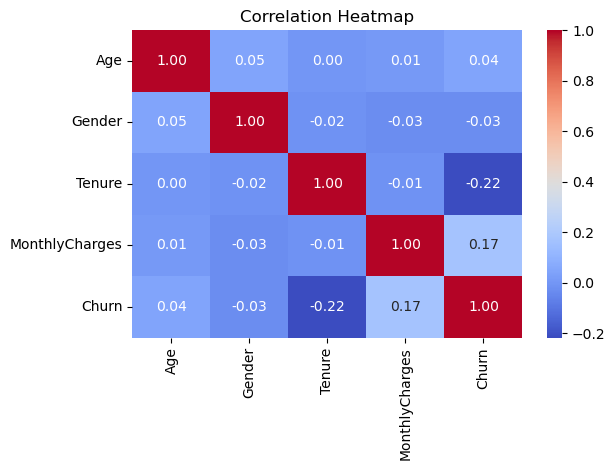

In [26]:
df_corr = pd.concat([X, y], axis=1)
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()

#### Observations
* Tenure has a negative correlation (-0.22) with churn – longer-term customers are less likely to leave.
* MonthlyCharges positively correlates (0.17) with churn – higher charges may lead to more churn.
* Gender and Age show very weak correlation with churn.

#### Machine Learning Models for Churn Prediction

#### XGBClassifier (eXtreme Gradient Boosting)

In [27]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# XGB parameters 
XGB_params = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10],
    "learning_rate": [0.01, 0.1],
    "subsample": [0.8, 1],
    "colsample_bytree": [0.8, 1]
}

# Initialize XGBoost model
model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train model with GridSearchCV
grid_XGB = GridSearchCV(model, XGB_params, scoring="f1_weighted", cv=5, n_jobs=-1)
grid_XGB.fit(X_train, y_train)

# Predict on test data
y_pred = grid_XGB.predict(X_test)

# Evaluate model
print(" Best Parameters:", grid_XGB.best_params_)
print(" Classification Report:\n", classification_report(y_test, y_pred, digits=2))
print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

 Best Parameters: {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}
 Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.04      0.08        23
           1       0.89      0.99      0.94       177

    accuracy                           0.89       200
   macro avg       0.69      0.52      0.51       200
weighted avg       0.84      0.89      0.84       200

 Confusion Matrix:
 [[  1  22]
 [  1 176]]


#### Observations
* Precision = 0.50, Recall = 0.04 for class 0 (Not Churned), which means the model is failing to correctly identify customers who are not likely to churn.
* Although churn prediction focuses on detecting churners (class 1), it is important to maintain balance across both classes.
* If the model misclassifies too many loyal customers as churners, it may lead to unnecessary retention efforts and wasted business resources.


#### The dataset exhibits significant class imbalance, leading to poor performance on the minority class. To enhance model learning and ensure balanced representation, we apply SMOTE for balance the classes and enhance model reliability.

#### XGB Classifier With SMOTE

In [28]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# SMOTE to balance
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# XGB parameters 
XGB_params = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10],
    "learning_rate": [0.01, 0.1],
    "subsample": [0.8, 1],
    "colsample_bytree": [0.8, 1]
}

# Initialize XGBoost model
model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train model with GridSearchCV
grid_XGB = GridSearchCV(model, XGB_params, scoring="f1_weighted", cv=5, n_jobs=-1)
grid_XGB.fit(X_train_sm, y_train_sm)

# Predict on test data
y_pred = grid_XGB.predict(X_test)
y_proba = grid_XGB.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

# Evaluate model
print(" Best Parameters:", grid_XGB.best_params_)
print(" Classification Report:\n", classification_report(y_test, y_pred, digits=2))
print(" Accuracy Score:", round(acc, 2))
print(" AUC-ROC Score:", round(auc, 2))
print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

 Best Parameters: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}
 Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.65      0.42        23
           1       0.95      0.81      0.87       177

    accuracy                           0.79       200
   macro avg       0.63      0.73      0.64       200
weighted avg       0.87      0.79      0.82       200

 Accuracy Score: 0.79
 AUC-ROC Score: 0.84
 Confusion Matrix:
 [[ 15   8]
 [ 34 143]]


#### Random Forest Classifier With SMOTE

In [29]:
# Random Forest parameters
rf_params = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, 15],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt"],
    "bootstrap": [True]
}

# Initialize Random Forest model
model = RandomForestClassifier(random_state=42, class_weight="balanced")

# Train model with GridSearchCV
grid_rf = GridSearchCV(model, rf_params, scoring="f1_weighted", cv=5, n_jobs=-1)
grid_rf.fit(X_train_sm, y_train_sm)

# Predict on test data
y_pred = grid_rf.predict(X_test)
y_proba = grid_rf.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

# Evaluate model
print(" Best Parameters:", grid_rf.best_params_)
print(" Classification Report:\n", classification_report(y_test, y_pred, digits=2))
print(" Accuracy Score:", round(acc, 2))
print(" AUC-ROC Score:", round(auc, 2))
print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

 Best Parameters: {'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
 Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.78      0.51        23
           1       0.97      0.84      0.90       177

    accuracy                           0.83       200
   macro avg       0.68      0.81      0.71       200
weighted avg       0.90      0.83      0.85       200

 Accuracy Score: 0.83
 AUC-ROC Score: 0.86
 Confusion Matrix:
 [[ 18   5]
 [ 29 148]]


#### Gradient Boosting Classifier With SMOTE

In [30]:
# Gradient Boosting parameters
gb_params = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

# Initialize GradientBoosting model
model = GradientBoostingClassifier(random_state=42)

# Train model with GridSearchCV
grid_gb = GridSearchCV(model, gb_params, scoring="f1_weighted", cv=5, n_jobs=-1)
grid_gb.fit(X_train_sm, y_train_sm)

# Predict on test data
y_pred = grid_gb.predict(X_test)
y_proba = grid_gb.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

# Evaluate model
print(" Best Parameters:", grid_gb.best_params_)
print(" Classification Report:\n", classification_report(y_test, y_pred, digits=2))
print(" Accuracy Score:", round(acc, 2))
print(" AUC-ROC Score:", round(auc, 2))
print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

 Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
 Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.74      0.54        23
           1       0.96      0.87      0.91       177

    accuracy                           0.85       200
   macro avg       0.69      0.80      0.73       200
weighted avg       0.90      0.85      0.87       200

 Accuracy Score: 0.85
 AUC-ROC Score: 0.85
 Confusion Matrix:
 [[ 17   6]
 [ 23 154]]


#### Cat Boost Classifier With SMOTE

In [31]:
# CatBoost parameters
cb_params = {
    'iterations': [100, 200],
    'depth': [4, 6, 8],
    'learning_rate': [0.03, 0.1],
    'l2_leaf_reg': [1, 3, 5]
}

# Initialize CatBoost model
model = CatBoostClassifier(verbose=0, random_state=42)

# Train model with GridSearchCV
grid_cb = GridSearchCV(model, cb_params, scoring="f1_weighted", cv=5, n_jobs=-1)
grid_cb.fit(X_train_sm, y_train_sm)

# Predict on test data
y_pred = grid_cb.predict(X_test)
y_proba = grid_cb.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

# Evaluate model
print(" Best Parameters:", grid_cb.best_params_)
print(" Classification Report:\n", classification_report(y_test, y_pred, digits=2))
print(" Accuracy Score:", round(acc, 2))
print(" AUC-ROC Score:", round(auc, 2))
print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

 Best Parameters: {'depth': 8, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
 Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.65      0.44        23
           1       0.95      0.83      0.89       177

    accuracy                           0.81       200
   macro avg       0.64      0.74      0.66       200
weighted avg       0.88      0.81      0.83       200

 Accuracy Score: 0.81
 AUC-ROC Score: 0.84
 Confusion Matrix:
 [[ 15   8]
 [ 30 147]]


#### Decision Tree Classifier

In [32]:
# Decision Tree parameters
dt_params = {
    "max_depth": [5, 10, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"]
}

# Initialize Decion Tree model
model = DecisionTreeClassifier(random_state=42, class_weight="balanced")

# Train model with GridSearchCV
grid_dt = GridSearchCV(model, dt_params, scoring="f1_weighted", cv=5, n_jobs=-1)
grid_dt.fit(X_train_sm, y_train_sm)

# Predict on test data
y_pred = grid_dt.predict(X_test)
y_proba = grid_dt.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

# Evaluate model
print(" Best Parameters:", grid_dt.best_params_)
print(" Classification Report:\n", classification_report(y_test, y_pred, digits=2))
print(" Accuracy Score:", round(acc, 2))
print(" AUC-ROC Score:", round(auc, 2))
print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

 Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
 Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.70      0.42        23
           1       0.95      0.79      0.86       177

    accuracy                           0.78       200
   macro avg       0.63      0.74      0.64       200
weighted avg       0.88      0.78      0.81       200

 Accuracy Score: 0.78
 AUC-ROC Score: 0.78
 Confusion Matrix:
 [[ 16   7]
 [ 37 140]]


#### Model Comparison for Churn Prediction
| Model                 | F1-Score (Churn=1) | Recall (Churn=1) | Precision (Churn=1) | Accuracy | AUC-ROC  |
| --------------------- | ------------------ | ---------------- | ------------------- | -------- | -------- |
| **Gradient Boosting** | 0.91               | 0.87             | 0.96                | 0.85     | 0.85     |
| **Random Forest**     | 0.90               | 0.84             | 0.97                | 0.83     | 0.86     |
| **CatBoost**          | 0.89               | 0.83             | 0.95                | 0.81     | 0.84     |
| **XGBoost**           | 0.87               | 0.81             | 0.95                | 0.79     | 0.84     |
| **Decision Tree**     | 0.86               | 0.79             | 0.95                | 0.78     | 0.78     |


#### Final Model Selection: Gradient Boosting Classifier

#### Reasons For Selecting Gradient Boosting Classifier
* **Superior F1-score (0.91):** Indicates an excellent balance between precision and recall, critical for imbalanced churn data, where both false positives and false negatives are costly.
* **Highest Accuracy (0.85):** Reflects strong overall performance, minimizing misclassifications across both churned and non-churned customers.
* **Robust Precision (0.96):** Shows high confidence in predicting churners (class 1), meaning fewer false positives and more targeted retention efforts.
* **Excellent AUC (0.85):** Demonstrates the model’s strong ability to separate churners from non-churners, supporting reliable decision-making.
* **Reasonable Performance on Non-Churned Class (F1-score: 0.54):** Despite class imbalance, the model still achieves decent identification of non-churned customers (class 0), ensuring balanced attention across both customer types.

In summary, Gradient Boosting delivers the most consistent and reliable performance across key metrics, making it the definitive model for churn prediction.

#### Save Model for Deployment

In [33]:
# Step 1: Get best model from GridSearchCV
best_model = grid_gb.best_estimator_

# Step 2: Save it
joblib.dump(best_model, "churn_gb_model_.pkl")

['churn_gb_model_.pkl']

#### Key Insights
* Customers with lower tenure  are more likely to churn, early engagement is critical.
* High monthly charges correlate with increased churn.
* Customers with high bills and short tenure are at highest risk.
* Senior Citizens show slightly higher churn rates than younger customers.

#### Recommendations
* Churned customers pay higher charges. Reviewing pricing plans or providing promotions/discounts to retain these high-risk, high-paying customers.
* Churn increases with age; consider designing age-specific loyalty programs or promotions.
* Consider onboarding initiatives such as “welcome packages”, “quick start guides”, or “new-customer incentives” to help first-year customers find more value in your service.
* Offer gifts or discounts to celebrate tenure milestones at 3, 6, and 12 months.